In [23]:
import numpy as np
import random, math, copy
import matplotlib.pyplot as plt
import sys


In [24]:
from numpy.random import rand
from numpy.random import choice
from numpy import asarray
from numpy import clip
from numpy import argmax
from numpy import min
from numpy import around

In [25]:
def GrieFunc(data): #Objective function
    s1 = 0.
    s2 = 1.
    for k, x in enumerate(data):
        s1 = s1 + x ** 2
        s2 = s2 * math.cos(x/math.sqrt(k+1))
    y = (1./4000.) * s1-s2 + 1
    return 1./(1. + y)

In [26]:
def Sphere(x):
    ss=sum(np.power(x, 2))
    return ss

In [27]:
def RastFunc(data):
    """
    Rastrigin function
    """
    s = 10 * 25
    for i in data:
        s = s + i ** 2 - 10 * math.cos(2 * math.pi * i)
    return 1./(1.+s)

In [28]:
class ABSIndividual:
    def __init__(self, bound):
        self.score = 0.
        self.invalidCount = 0 #Invalid times (the cumulative number of times the score is not updated)
        self.chrom = [random.uniform(a,b) for a,b in zip(bound[0,:],bound[1,:])] #random initialization
        self.calculateFitness()        

    def calculateFitness(self):
        self.score = GrieFunc(self.chrom)
        #self.score = Sphere(self.chrom)
        #self.score = RastFunc(self.chrom)  

In [29]:

# define mutation operation
def mutation(x, F):
    return x[0] + F * (x[1] - x[2])


# define boundary check operation
def check_bounds(mutated, bounds):
    mutated_bound = [clip(mutated[i], bounds[0,i], bounds[1,i]) for i in range(len(bounds[0]))]
    return mutated_bound


# define crossover operation
def crossover(mutated, target, dims, cr):
    # generate a uniform random value for every dimension
    p = rand(dims)
    # generate trial vector by binomial crossover
    trial = [mutated[i] if p[i] < cr else target[i] for i in range(dims)]
    return trial


In [47]:
class ArtificialBeeSwarm:
    def __init__(self, foodCount, onlookerCount, bound, maxIterCount=1000, maxInvalidCount=200):
        self.foodCount = foodCount                 
        self.onlookerCount = onlookerCount           
        self.bound = bound
        self.F = 0.5  # define scale factor for mutation
        self.cr=0.7  # define crossover rate for recombination
        self.maxIterCount = maxIterCount           
        self.maxInvalidCount = maxInvalidCount    
        self.foodList = [ABSIndividual(self.bound) for k in range(self.foodCount)]
        self.foodScore = [d.score for d in self.foodList]  
        self.bestFood = self.foodList[np.argmax(self.foodScore)]

        

    def updateFood(self, i):         
#         k = random.randint(0, self.bound.shape[1] - 1) 
#         j = random.choice([d for d in range(self.bound.shape[1]) if d !=i])   
#         vi = copy.deepcopy(self.foodList[i])
#         vi.chrom[k] += random.uniform(-1.0, 1.0) * (vi.chrom[k] - self.foodList[j].chrom[k]) 
#         vi.chrom[k] = np.clip(vi.chrom[k], self.bound[0, k], self.bound[1, k])              
#         vi.calculateFitness()
#         if vi.score > self.foodList[i].score:          
#             self.foodList[i] = vi
#             if vi.score > self.foodScore[i]:           
#                 self.foodScore[i] = vi.score
#                 if vi.score > self.bestFood.score:      
#                     self.bestFood = vi
#             self.foodList[i].invalidCount = 0
#         else:
#             self.foodList[i].invalidCount += 1
        
        
        k = random.randint(0, self.bound.shape[1] - 1)
        j = random.choice([d for d in range(self.bound.shape[1]) if d !=i])  
        vj = copy.deepcopy(self.foodList[i]) 
        candidates = [candidate for candidate in range(self.foodCount) if candidate != i]
        pop=np.array([d.chrom for d in self.foodList] )
        a, b, c = pop[choice(candidates, 3, replace=False)]
            # perform mutation
        mutated = mutation([a, b, c], self.F)
            # check that lower and upper bounds are retained after mutation
        mutated = check_bounds(mutated, self.bound)
            # perform crossover
        #print(pop[i])
        trial = crossover(mutated, pop[i], len(self.bound[0]), self.cr)
        pop[i]=trial
        self.foodList[i].chrom=trial
#         for pp,d in enumerate(self.foodList):
#              d.chrom=pop[pp]        
        vi = copy.deepcopy(self.foodList[i])
#         vi.chrom[k] += random.uniform(-1.0, 1.0) * (vi.chrom[k] - self.foodList[j].chrom[k])
#         vi.chrom[k] = np.clip(vi.chrom[k], self.bound[0, k], self.bound[1, k])  
        vi.calculateFitness()
        #print(vi.score,vj.score)
        
        if vi.score > vj.score:           
            self.foodList[i] = vi
            if vi.score > self.foodScore[i]:            
                self.foodScore[i] = vi.score
                if vi.score > self.bestFood.score:     
                    self.bestFood = vi
            self.foodList[i].invalidCount = 0
        else:
            self.foodList[i].invalidCount += 1
            
    def employedBeePhase(self):
        for i in range(0, self.foodCount):              
            self.updateFood(i)            

    def onlookerBeePhase(self):
        foodScore = [d.score for d in self.foodList]  
        maxScore = np.max(foodScore)        
        accuFitness = [(0.9*d/maxScore+0.1, k) for k,d in enumerate(foodScore)] 
        for k in range(0, self.onlookerCount):
            i = random.choice([d[1] for d in accuFitness if d[0] >= random.random()]) 
            self.updateFood(i)

    def scoutBeePhase(self):
        for i in range(0, self.foodCount):
            if self.foodList[i].invalidCount > self.maxInvalidCount:                    
                self.foodList[i] = ABSIndividual(self.bound)
                self.foodScore[i] = max(self.foodScore[i], self.foodList[i].score)

    def solve(self):
        trace = []
        trace.append((self.bestFood.score, np.mean(self.foodScore)))

    
        for k in range(self.maxIterCount):
            self.employedBeePhase()
            self.onlookerBeePhase()
            #self.employedBeePhase()
            self.scoutBeePhase()
            trace.append((self.bestFood.score, np.mean(self.foodScore)))
            print(self.bestFood.score)
        self.printResult(np.array(trace))

    def printResult(self, trace):
        y = np.arange(0, trace.shape[0])
        plt.plot(y, [(1-d)/d for d in trace[:, 0]], 'r', label='optimal value')
        plt.plot(y, [(1-d)/d for d in trace[:, 1]],'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Artificial Bee Swarm algorithm for function optimization")
        plt.legend()
        plt.show()

[[-600 -600 -600 -600 -600 -600 -600 -600 -600 -600 -600 -600 -600 -600
  -600 -600 -600 -600 -600 -600 -600 -600 -600 -600 -600]
 [ 600  600  600  600  600  600  600  600  600  600  600  600  600  600
   600  600  600  600  600  600  600  600  600  600  600]]
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.0024219183780678447
0.00242191837

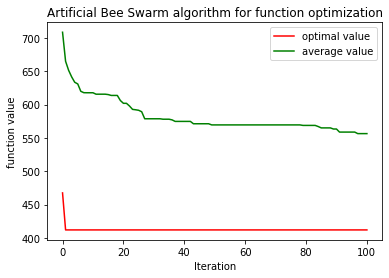

In [50]:
if __name__ == "__main__":
    random.seed()
    vardim = 25
    bound = np.tile([[-600], [600]], vardim)
    print(bound)
    abs = ArtificialBeeSwarm(30, 30, bound, 100, 200)
    #(foodCount, onlookerCount, bound, maxIterCount=1000, maxInvalidCount=200)
    abs.solve()